In [15]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import tensorflow as tf
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional,BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score

In [16]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, holistic_model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = holistic_model.process(image)        # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results):
    # Trích xuất keypoints của bàn tay trái (left_hand_landmarks)
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark])
    else:
        lh = np.zeros((21, 2))  # shape (21, 2) vì mỗi keypoint có 2 giá trị (x, y)
    return lh

def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [17]:
def normalize_keypoints(keypoints):
    # Kiểm tra nếu có đủ số điểm (21 điểm cho mỗi bàn tay)
    if keypoints.shape[0] != 21:
        raise ValueError(f"Số lượng điểm keypoints không hợp lệ: {keypoints.shape[0]}")

    # Cổ tay là điểm đầu tiên trong keypoints (index 0)
    wrist = keypoints[0]
    
    # Dịch các điểm sao cho cổ tay trở thành gốc tọa độ (0, 0)
    normalized_keypoints = []
    for point in keypoints:
        normalized_point = (point[0] - wrist[0], point[1] - wrist[1])  # Chỉ cần dịch x, y
        normalized_keypoints.append(normalized_point)
    
    # Chuyển sang numpy array để dễ dàng tính toán min và max
    normalized_keypoints = np.array(normalized_keypoints)
    
    # Tính toán min và max cho x và y
    x_min, y_min = np.min(normalized_keypoints, axis=0)
    x_max, y_max = np.max(normalized_keypoints, axis=0)
    
    # Tránh chia cho 0 nếu max - min = 0
    if (x_max - x_min) == 0:
        print("Cảnh báo: Tọa độ x không thay đổi, bỏ qua chuẩn hóa x.")
        x_min, x_max = 0, 1  # Cứ để giá trị x giữ nguyên, hoặc chọn giá trị mặc định
    if (y_max - y_min) == 0:
        print("Cảnh báo: Tọa độ y không thay đổi, bỏ qua chuẩn hóa y.")
        y_min, y_max = 0, 1  # Cứ để giá trị y giữ nguyên, hoặc chọn giá trị mặc định
    
    # Chuyển min và max về dạng numpy array để có thể tính toán đúng
    min_vals = np.array([x_min, y_min])
    max_vals = np.array([x_max, y_max])
    
    # Chuẩn hóa về phạm vi [-1, 1]
    normalized_keypoints = 2 * (normalized_keypoints - min_vals) / (max_vals - min_vals) - 1
    
    return normalized_keypoints

In [18]:
def process_images(data_dir, output_dir):
    # Duyệt qua từng class trong thư mục
    classes = os.listdir(data_dir)
    for action in classes:
        class_folder = os.path.join(data_dir, action)
        if not os.path.isdir(class_folder):
            continue

        # Tạo thư mục lưu keypoints
        npy_class_dir = os.path.join(output_dir, action)
        os.makedirs(npy_class_dir, exist_ok=True)
        print(f"Đang xử lý lớp: {action}")

        # Duyệt qua từng ảnh trong class
        images = [f for f in os.listdir(class_folder) if f.endswith('.jpg')]
        images.sort()  # Đảm bảo xử lý theo thứ tự frame1, frame2, ...
        
        with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
            for img_idx, image_file in enumerate(images):
                image_path = os.path.join(class_folder, image_file)
                
                # Đọc ảnh
                frame = cv2.imread(image_path)
                if frame is None:
                    print(f"Không thể đọc ảnh: {image_path}")
                    continue

                # Trích xuất đặc trưng
                image, results = mediapipe_detection(frame, holistic)
                keypoints = extract_keypoints(results)
                
                keypoints = normalize_keypoints(keypoints)

                # Lưu đặc trưng vào file .npy
                npy_path = os.path.join(npy_class_dir, f"{img_idx}.npy")
                np.save(npy_path, keypoints)

                print(f"Lớp {action}: Lưu keypoints từ ảnh {image_file} vào {npy_path}")
                
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    cv2.destroyAllWindows()
                    return

    cv2.destroyAllWindows()

In [19]:
# Cấu trúc thư mục
data_dir = 'data'  # Thư mục chứa các lớp (class1, class2, ...)
output_dir = 'data_normalized'  # Thư mục để lưu keypoints dưới dạng .npy
process_images(data_dir, output_dir)

Đang xử lý lớp: movement
Lớp movement: Lưu keypoints từ ảnh frame_000.jpg vào data_normalized\movement\0.npy
Lớp movement: Lưu keypoints từ ảnh frame_001.jpg vào data_normalized\movement\1.npy
Lớp movement: Lưu keypoints từ ảnh frame_002.jpg vào data_normalized\movement\2.npy
Lớp movement: Lưu keypoints từ ảnh frame_003.jpg vào data_normalized\movement\3.npy
Lớp movement: Lưu keypoints từ ảnh frame_004.jpg vào data_normalized\movement\4.npy
Lớp movement: Lưu keypoints từ ảnh frame_005.jpg vào data_normalized\movement\5.npy
Lớp movement: Lưu keypoints từ ảnh frame_006.jpg vào data_normalized\movement\6.npy
Lớp movement: Lưu keypoints từ ảnh frame_007.jpg vào data_normalized\movement\7.npy
Lớp movement: Lưu keypoints từ ảnh frame_008.jpg vào data_normalized\movement\8.npy
Lớp movement: Lưu keypoints từ ảnh frame_009.jpg vào data_normalized\movement\9.npy
Lớp movement: Lưu keypoints từ ảnh frame_010.jpg vào data_normalized\movement\10.npy
Lớp movement: Lưu keypoints từ ảnh frame_011.jpg v

In [20]:
classes = ['movement', 'other']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'movement': 0, 'other': 1}

In [21]:
def create_dataset():
    data, labels = [], []

    # Duyệt qua tất cả các lớp hành động
    for action in classes:
        # Thư mục chứa các file .npy của lớp hành động
        action_folder = os.path.join('data_normalized', action)
        
        if not os.path.exists(action_folder):
            print(f"Thư mục {action_folder} không tồn tại.")
            continue

        # Lấy danh sách các file .npy trong lớp hành động, sắp xếp theo thứ tự
        npy_files = sorted([f for f in os.listdir(action_folder) if f.endswith('.npy')], key=lambda x: int(x.split('.')[0]))
        
        print(f"Đang xử lý {len(npy_files)} files cho lớp {action}.")
        
        # Duyệt qua từng file .npy và lưu dữ liệu
        for npy_file in npy_files:
            file_path = os.path.join(action_folder, npy_file)
            features = np.load(file_path)  # Đọc file .npy
            data.append(features)
            labels.append(label_map[action])  # Gắn nhãn tương ứng với hành động

    return np.array(data), np.array(labels)

sequences, labels = create_dataset()

print(f"Tổng số sequences: {len(sequences)}")
print(f"Tổng số labels: {len(labels)}")
print(f"Shape của sequences: {np.array(sequences).shape}")
print(f"Shape của labels: {np.array(labels).shape}")

# print(sequences, labels)

Đang xử lý 326 files cho lớp movement.
Đang xử lý 522 files cho lớp other.
Tổng số sequences: 848
Tổng số labels: 848
Shape của sequences: (848, 21, 2)
Shape của labels: (848,)


In [22]:
np.save("data.npy", sequences)
np.save("labels.npy", labels)

In [23]:
X = np.array(sequences)
y = np.array(labels)

print(X.shape)
print(y.shape)

(848, 21, 2)
(848,)


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_val.shape

# print(y_train)

(170,)

In [25]:
# Xây dựng mô hình
model = Sequential([
    Dense(128, activation='relu', input_shape=(21,2)),  # Lớp đầu vào
    Flatten(),
    Dropout(0.1),  # Dropout để giảm overfitting
    Dense(64, activation='relu'),  # Lớp ẩn
    Dropout(0.1),  # Dropout
    Dense(1, activation='sigmoid')  # Lớp đầu ra
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 21, 128)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       172,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,545 (674.00 KB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7565 - loss: 0.4951 - val_accuracy: 0.9235 - val_loss: 0.3248
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9437 - loss: 0.2059 - val_accuracy: 0.9294 - val_loss: 0.2545
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9543 - loss: 0.1406 - val_accuracy: 0.9882 - val_loss: 0.2092
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.0994 - val_accuracy: 0.9529 - val_loss: 0.2089
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.0640 - val_accuracy: 0.9941 - val_loss: 0.2033
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9823 - loss: 0.0651 - val_accuracy: 0.9941 - val_loss: 0.2092
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9873 - loss: 0.0472 - val_accuracy: 0.9588 - val_loss: 0.2240
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9740 - loss: 0.0741 - val_accuracy: 0.9941 - 

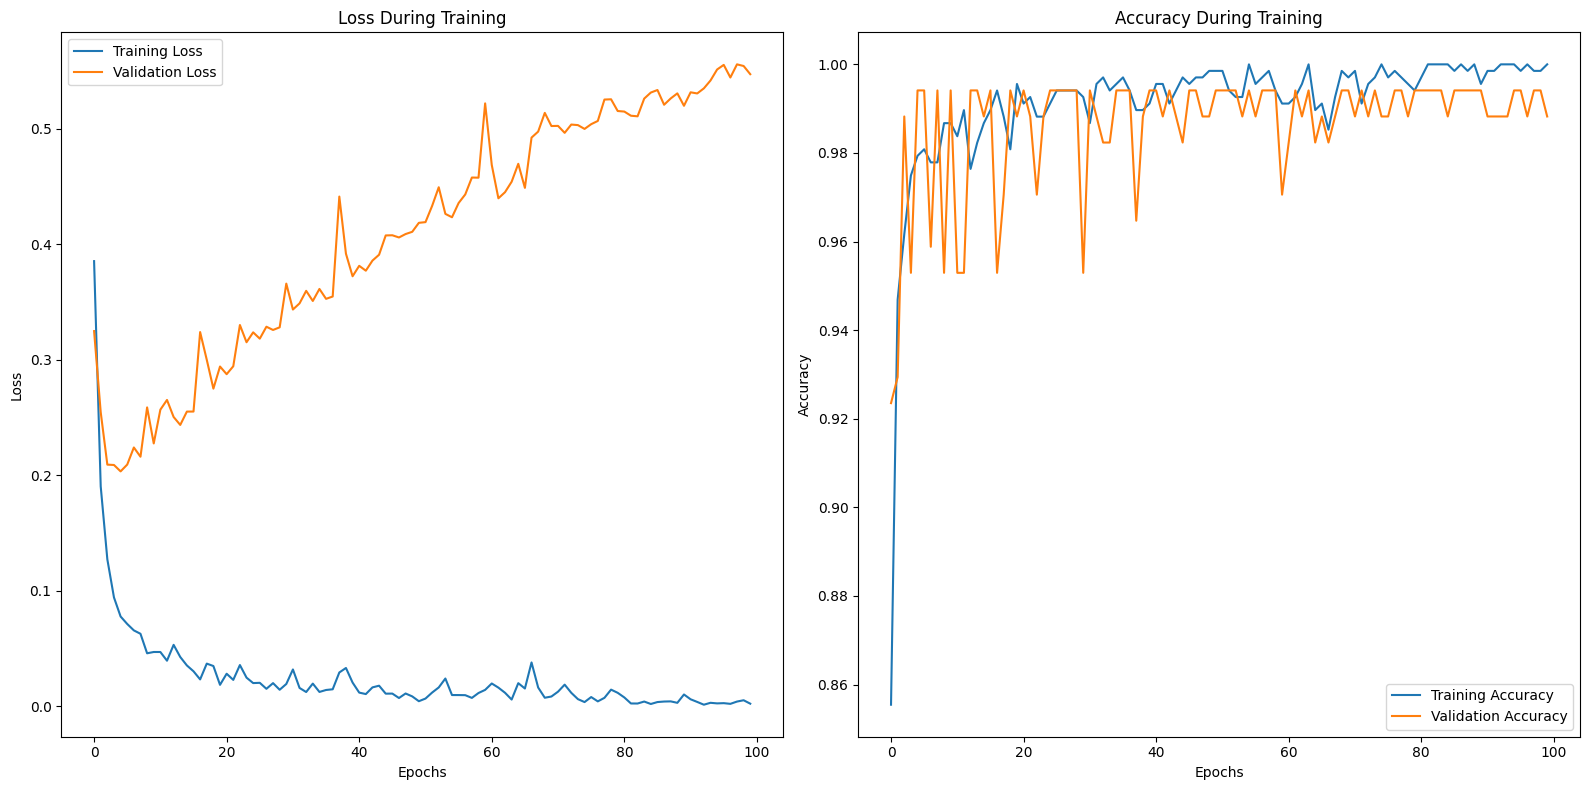

In [13]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(16, 8))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# res = model.predict(X_test)
# # classes[np.argmax(res[4])]
# print(res)

In [17]:
# yhat = model.predict(X_test)
# ytrue = y_test

# yhat = (yhat > 0.5).astype(int)

# confusion_matrix(y_test, yhat)

In [14]:
cap = cv2.VideoCapture(0)

frame_counter = 0

with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        frame_counter += 1  # Tăng biến đếm lên mỗi khi đọc khung hình
        if frame_counter % 30 != 0:  # Chỉ xử lý mỗi khung hình thứ 3 (tùy chỉnh)
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        
        print(keypoints.shape)
        
        keypoints = normalize_keypoints(keypoints)
        
        print(f"Shape before expansion: {keypoints.shape}")
        
        # Thêm một chiều để đưa vào mô hình (cần có shape (1, 21, 2))
        keypoints = np.expand_dims(keypoints, axis=0)
        
        print(f"Shape after expansion: {keypoints.shape}")

        # Dự đoán với mô hình
        res = model.predict(keypoints)
        print(res)

        # Kiểm tra dự đoán
        if res[0] > 0.5:
            print('Other')
        else:
            print('Movement')
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Cảnh báo: Tọa độ x không thay đổi, bỏ qua chuẩn hóa x.
Cảnh báo: Tọa độ y không thay đổi, bỏ qua chuẩn hóa y.
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[1.]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[1.]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[1.]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[1.]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

In [19]:
model.save('movement_check.keras')